In [1]:
# from pathml.utils import plot_segmentation
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import glob
import scipy.io as sio
from tqdm import tqdm
from pathlib import Path
import os
import pickle
from scanpy import read_h5ad
import squidpy as sq
import pandas as pd
import json
import matplotlib.patches as mpatches
from PIL import Image
import matplotlib as mpl
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from squidpy.im import ImageContainer 
from sklearn.metrics import accuracy_score, classification_report
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
classes_c = {
    'Immune': [255, 0, 0],           # Red
    'Stromal': [0, 255, 0],          # Green
    'Cancer Epithelial': [0, 0, 255], # Blue
    'Endothelial': [255, 255, 0]     # Yellow
}

def mask_to_geojson(masks, output_file, classes, simplify_tolerance=0.0):
    """
    Convert segmentation masks into a GeoJSON file for QuPath.

    Args:
        masks (np.ndarray): Mask array of shape (n_masks, H, W). Zeroes are background pixels.
        output_file (str): Path to the output GeoJSON file.
        classes (list): List of class names corresponding to each mask channel.
        simplify_tolerance (float): Optional simplification tolerance for reducing point density. Defaults to 0.
    """
    from shapely.geometry import Polygon, mapping
    import json
    import cv2
    import numpy as np

    geojson_dict = {
        "type": "FeatureCollection",
        "features": []
    }

    n_channels = masks.shape[0]
    
    for i in range(n_channels):
        unique_labels = np.unique(masks[i, ...])
        if 0 in unique_labels:
            unique_labels = unique_labels[unique_labels != 0]  # Exclude background

        for label in unique_labels:
            mask = (masks[i, ...] == label).astype(np.uint8)

            # Find contours for the current mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                # Convert contour to GeoJSON-friendly coordinates
                coords = contour.squeeze().tolist()

                if len(coords) < 3:
                    continue  # Skip invalid polygons with fewer than 3 points

                # Create a Shapely Polygon and simplify if necessary
                polygon = Polygon(coords)
                if simplify_tolerance > 0:
                    polygon = polygon.simplify(simplify_tolerance)

                # Create a feature for the polygon
                feature = {
                    "type": "Feature",
                    "geometry": mapping(polygon),
                    "properties": {
                        "objectType": "cell",
                        "classification": {
                            "name": classes[i],
                            "color": classes_c[classes[i]]  # Default color, you may want to assign specific colors
                        },
                        "isLocked": False
                    }
                }

                geojson_dict["features"].append(feature)

    # Write the GeoJSON to file
    with open(output_file, 'w') as f:
        json.dump(geojson_dict, f)

    print(f"GeoJSON file saved as {output_file}")

In [3]:
def segmentation_lines(mask_in):
    """
    Generate coords of points bordering segmentations from a given mask.
    Useful for plotting results of tissue detection or other segmentation.
    """
    assert (
        mask_in.dtype == np.uint8
    ), f"Input mask dtype {mask_in.dtype} must be np.uint8"
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(mask_in, kernel)
    diff = np.logical_xor(dilated.astype(bool), mask_in.astype(bool))
    y, x = np.nonzero(diff)
    return x, y


def plot_segmentation(masks, ax, palette=None, markersize=5):
    """
    Plot segmentation contours. Supports multi-class masks.

    Args:
        ax: matplotlib axis
        masks (np.ndarray): Mask array of shape (n_masks, H, W). Zeroes are background pixels.
        palette: color palette to use. if None, defaults to matplotlib.colors.TABLEAU_COLORS
        markersize (int): Size of markers used on plot. Defaults to 5
    """
    assert masks.ndim == 3
    n_channels = masks.shape[0]

    if palette is None:
        palette = list(TABLEAU_COLORS.values())

    nucleus_labels = list(np.unique(masks))
    if 0 in nucleus_labels:
        nucleus_labels.remove(0)  # background
    # plot each individual nucleus
    for label in nucleus_labels:
        for i in range(n_channels):
            nuclei_mask = masks[i, ...] == label
            x, y = segmentation_lines(nuclei_mask.astype(np.uint8))
            ax.scatter(x, y, color=palette[i], marker=".", s=markersize)

In [4]:
import numpy as np

def calculate_metrics_multiclass_masks(ground_truth, prediction, class_names):
    """
    Calculate IoU, Dice, Precision, Recall, and F1 for multi-class masks 
    (shape: (n_classes, H, W)) and compute mean scores across all classes.

    Args:
        ground_truth (np.ndarray): Ground truth binary masks of shape (n_classes, H, W).
        prediction (np.ndarray): Predicted binary masks of shape (n_classes, H, W).
        class_names (list): List of class names corresponding to the masks.

    Returns:
        dict: A dictionary containing metrics for each class and the mean scores.
    """
    assert ground_truth.shape == prediction.shape, "Shapes of ground truth and prediction must match"
    assert ground_truth.shape[0] == len(class_names), "Number of classes must match the length of class_names"
    n_classes = ground_truth.shape[0]
    metrics_per_class = []
    ground_truth[ground_truth>0] = 1
    prediction[prediction>0] = 1
    for class_label, class_name in enumerate(class_names):
        gt_mask = ground_truth[class_label, ...].flatten()
        pred_mask = prediction[class_label, ...].flatten()
        
        # Calculate intersection and union
        intersection = np.sum(gt_mask * pred_mask)
        union = np.sum(gt_mask) + np.sum(pred_mask) - intersection

        # Calculate metrics
        iou = intersection / union if union != 0 else 0
        dice = 2 * intersection / (np.sum(gt_mask) + np.sum(pred_mask)) if (np.sum(gt_mask) + np.sum(pred_mask)) != 0 else 0
        precision = intersection / np.sum(pred_mask) if np.sum(pred_mask) != 0 else 0
        recall = intersection / np.sum(gt_mask) if np.sum(gt_mask) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        metrics_per_class.append({
            "Class": class_name,
            "IoU": iou,
            "Dice": dice,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

    # Calculate mean metrics across all classes
    mean_metrics = {
        "Mean IoU": np.mean([m["IoU"] for m in metrics_per_class]),
        "Mean Dice": np.mean([m["Dice"] for m in metrics_per_class]),
        "Mean Precision": np.mean([m["Precision"] for m in metrics_per_class]),
        "Mean Recall": np.mean([m["Recall"] for m in metrics_per_class]),
        "Mean F1": np.mean([m["F1"] for m in metrics_per_class]),
    }

    return metrics_per_class, mean_metrics

In [5]:
import subprocess
from pathlib import Path
from datetime import datetime
import os
PROJECT = "Pete"
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")
system = subprocess.check_output(["hostname", "-s"]).decode("utf-8").strip()
BASE_PATH_ = Path()
if "bun" in system:
    BASE_PATH_ = Path("/QRISdata/Q1851/Xiao/")
elif "imb-quan-gpu" in system:
    BASE_PATH_ = Path("/home/uqxtan9/Q1851/Xiao/")
elif "gpunode" in system:
    BASE_PATH_ = Path("/scratch/imb/Xiao/Q1851/Xiao/")


TMP_PATH = Path("/scratch/temp/") / os.environ["SLURM_JOB_ID"]
SCRATCH_PATH = Path("/scratch/project_mnt/S0010/Xiao")
BASE_PATH = BASE_PATH_ / "Working_project" / PROJECT
DATA_PATH = BASE_PATH / "DATA/"
PROCESSED = BASE_PATH / "PROCESSED"
PROCESSED.mkdir(exist_ok=True, parents=True)
OUT_PATH = BASE_PATH / "OUT"
OUT_PATH.mkdir(exist_ok=True, parents=True)
QC_PATH = OUT_PATH / "QC"
QC_PATH.mkdir(exist_ok=True, parents=True)
CELL_TYPE_PATH = OUT_PATH / "CELL_TYPE"
CELL_TYPE_PATH.mkdir(exist_ok=True, parents=True)
NICHE_PATH = OUT_PATH / "NICHE"
NICHE_PATH.mkdir(exist_ok=True, parents=True)
CCI_PATH = OUT_PATH / "CCI"
CCI_PATH.mkdir(exist_ok=True, parents=True)
PRED_PATH = OUT_PATH / "PRED"
PRED_PATH.mkdir(exist_ok=True, parents=True)

In [6]:
TMP_PATH

PosixPath('/scratch/temp/12548117')

In [7]:

SAMPLE_ID = "QMDL02"
# Load the numpy files
img_path = PROCESSED / "images" / f"{SAMPLE_ID}.ome.tif"
result_path = TMP_PATH / f"hovernet_out_test_{SAMPLE_ID}"
adata_path = PROCESSED / f"annotated_labels/{SAMPLE_ID}/imputed_annotated.h5ad"
cm = np.load(result_path / "cm.npy")
preds = np.load(result_path / "preds.npy")
truths = np.load(result_path / "truths.npy")
pred_dir = result_path / "centroids_pred/"
true_dir = result_path / "centroids_truth/"
paths = np.load(result_path / "types.npy")
file_map = dict(enumerate([int(Path(p).stem.split('_')[1]) for p in paths]))

print(f"Shape of confusion matrix: {cm.shape}")
print(f"Number of predictions: {len(preds)}")
print(f"Number of ground truths: {len(truths)}")
print(f"Number of types: {len(paths)}")

Shape of confusion matrix: (5, 5)
Number of predictions: 4879
Number of ground truths: 4879
Number of types: 4879


In [8]:
palette = list(TABLEAU_COLORS.values())
palette = ['#FFFFFF'] + palette

In [9]:

img = ImageContainer(img_path)

size = 256
size = img._get_size(size)
size = img._convert_to_pixel_space(size)

y, x = img.shape
ys, xs = size
# _assert_in_range(ys, 0, y, name="height")
# _assert_in_range(xs, 0, x, name="width")

unique_ycoord = np.arange(start=0, stop=(y // ys + (y % ys != 0)) * ys, step=ys)
unique_xcoord = np.arange(start=0, stop=(x // xs + (x % xs != 0)) * xs, step=xs)

ycoords = np.repeat(unique_ycoord, len(unique_xcoord))
xcoords = np.tile(unique_xcoord, len(unique_ycoord))

mapping = dict(enumerate(zip(ycoords, xcoords)))

In [10]:
ordering = list(file_map.values())

In [11]:
preds = np.moveaxis(preds,3,1)
preds.shape

(4879, 5, 256, 256)

In [12]:
truths = np.moveaxis(truths,3,1)
truths.shape

(4879, 5, 256, 256)

In [13]:
# Stitch image back together
size = 256
img_true = np.zeros((truths.shape[1],ycoords.max()+size, xcoords.max()+size),dtype=np.uint8)

for n, idx in enumerate(tqdm(ordering)):
    y, x = mapping[idx]
    img_true[:,y:y+size,x:x+size] = truths[n]
    
img_true = img_true[:,:img.shape[0],:img.shape[1]]

np.save(result_path / 'truths_mapped.npy', img_true)

100%|██████████| 4879/4879 [00:02<00:00, 2278.86it/s]


In [14]:
img_true.shape

(5, 29753, 26735)

In [15]:
# Stitch image back together
size = 256
img_pred = np.zeros((preds.shape[1],ycoords.max()+size, xcoords.max()+size),dtype=np.uint8)

for n, idx in enumerate(tqdm(ordering)):
    y, x = mapping[idx]
    img_pred[:,y:y+size,x:x+size] = preds[n]
    
img_pred = img_pred[:,:img.shape[0],:img.shape[1]]

np.save(result_path / 'preds_mapped.npy', img_pred)

100%|██████████| 4879/4879 [00:01<00:00, 2955.34it/s]


In [16]:
# TRUE TO USE
file_list = glob.glob(str(true_dir) + '/' + '*.mat')
file_list.sort() # ensure same order [1]
transformed_all = []
types_all = []

for file_idx, filename in enumerate(tqdm(file_list[:])):
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]
    true_info = sio.loadmat(str(true_dir) + '/' + basename + '.mat')
    centroids = true_info['inst_centroid']
    pos = mapping[file_map[int(basename)-1]]
    # transformed = centroids + pos
    transformed = centroids + list(reversed(pos))
    types = true_info['inst_type'].astype(int)
    if file_idx == 0:
        transformed_all = transformed
        types_all = types
    else:
        transformed_all = np.concatenate((transformed, transformed_all))
        types_all = np.concatenate((types, types_all))

cols = list(map(dict(enumerate(palette)).get, types_all.flatten().tolist()))

100%|██████████| 4879/4879 [00:14<00:00, 329.88it/s]


In [17]:
with open(result_path / 'transformed_data_true.pkl', 'wb') as f:  # open a text file
    pickle.dump([transformed_all, types_all, cols], f) # serialize the list

In [18]:
with open(result_path / 'transformed_data_true.pkl', 'rb') as f:  # open a text file
    true_transformed_all, true_types_all, true_cols = pickle.load(f)

In [19]:
# PRED TO USE
file_list = glob.glob(str(pred_dir) + '/' + '*.mat')
file_list.sort() # ensure same order [1]
transformed_all = []
types_all = []

for file_idx, filename in enumerate(tqdm(file_list[:])):
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]
    pred_info = sio.loadmat(str(pred_dir) + '/' + basename + '.mat')
    centroids = pred_info['inst_centroid']
    if centroids.size > 0:
        pos = mapping[int(file_map[int(basename)-1])]
        # transformed = centroids + pos
        transformed = centroids + list(reversed(pos))
        types = pred_info['inst_type'].astype(int)
        if file_idx == 0:
            transformed_all = transformed
            types_all = types
        else:
            transformed_all = np.concatenate((transformed, transformed_all))
            types_all = np.concatenate((types, types_all))

cols = list(map(dict(enumerate(palette)).get, types_all.flatten().tolist()))

100%|██████████| 4879/4879 [00:13<00:00, 356.57it/s]


In [20]:
with open(result_path / 'transformed_data_pred.pkl', 'wb') as f:  # open a text file
    pickle.dump([transformed_all, types_all, cols], f) # serialize the list

In [21]:
with open(result_path / 'transformed_data_pred.pkl', 'rb') as f:  # open a text file
    pred_transformed_all, pred_types_all, pred_cols = pickle.load(f)

In [22]:
adata = read_h5ad(adata_path)
categories = adata.obs['predicted.id'].cat.categories.tolist()
colors = list(TABLEAU_COLORS.values())
legend_handles = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
filtered_legend_handles_ = [
    handle for handle, label in zip(legend_handles, colors)
    if label in set(pred_cols) or label in set(true_cols)
]

In [23]:
categories_map = {
        'B-cells': "Immune",
        'CAFs': "Stromal",
        'Cancer Epithelial': "Cancer Epithelial",
        'Endothelial': "Endothelial",
        'Myeloid': "Immune",
        'Normal Epithelial': "Cancer Epithelial",
        'PVL': "Endothelial",
        'Plasmablasts': "Immune",
        'T-cells': "Immune"
    }
new_categories = [categories_map[label] for _, label in zip(filtered_legend_handles_, categories)]
new_colors = [c for _, c in zip(filtered_legend_handles_, colors)]
filtered_legend_handles = [mpatches.Patch(color=new_colors[i], label=new_categories[i]) for i in range(len(new_categories))]

In [ ]:
fig, axes = plt.subplots(figsize=(12,8),ncols=2)

axes[0].scatter(pred_transformed_all[:,0], pred_transformed_all[:,1], c=pred_cols, s=0.1)
axes[1].scatter(true_transformed_all[:,0], true_transformed_all[:,1], c=true_cols, s=0.1)
axes[0].set_title("Predicted")
axes[1].set_title("Ground truth")
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set_aspect(1)
axes[1].set_aspect(1)


fig.suptitle('QMDL01', fontsize=16)
fig.legend(handles=filtered_legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(new_categories))
fig.tight_layout()
fig.savefig(PRED_PATH / "spatial_wsi_QMDL01.png", dpi=300)

In [24]:
# # swap y,x to be compatible with PIL
vals = img.data['image'].values.squeeze()
# # vals = np.moveaxis(vals, 1,0)
im = Image.fromarray(vals)

In [ ]:
fig, axes = plt.subplots(figsize=(18,8),ncols=3)

axes[0].scatter(pred_transformed_all[:,0], pred_transformed_all[:,1], c=pred_cols, s=0.1)
axes[1].scatter(true_transformed_all[:,0], true_transformed_all[:,1], c=true_cols, s=0.1)
axes[0].set_title("Predicted")
axes[1].set_title("Ground truth")
axes[2].set_title("H&E")
axes[0].set_ylim(0,img.shape[0])
axes[0].set_xlim(0,img.shape[1])
axes[1].set_ylim(0,img.shape[0])
axes[1].set_xlim(0,img.shape[1])
axes[2].imshow(im, aspect='auto', extent=axes[0].axis(), zorder=-1,origin='lower')
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[2].invert_yaxis()
axes[0].set_aspect(1)
axes[1].set_aspect(1)
axes[2].set_aspect(1)

fig.suptitle('QMDL01', fontsize=16)
fig.legend(handles=filtered_legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(new_categories))
fig.tight_layout()
fig.savefig(PRED_PATH / "spatial_wsi_QMDL01_HE.png", dpi=300, bbox_inches='tight')

In [25]:
label_dict = dict(enumerate(palette))
cat_color_dict = dict(zip(new_colors, new_categories))
cat_to_plot = [cat_color_dict[label_dict[i]] for i in range(1, 5)]

In [ ]:
cm_normalized = cm / cm.sum(axis=1, keepdims=True) * 100
annotations = np.empty_like(cm[1:5, 1:5]).astype(str)
for i in range(annotations.shape[0]):
    for j in range(annotations.shape[1]):
        count = cm[1:5, 1:5][i, j]
        percentage = cm_normalized[1:5, 1:5][i, j]
        annotations[i, j] = f"{int(count)}\n({percentage:.1f}%)"

# Plot confusion matrix with custom annotations
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized[1:5, 1:5], annot=annotations, fmt='', cmap='Blues', xticklabels=cat_to_plot, yticklabels=cat_to_plot)
plt.title('Confusion Matrix (QMDL01)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.show()
fig.tight_layout()
fig.savefig(PRED_PATH / "cm_QMDL01.png", dpi=300, bbox_inches='tight')

In [26]:
import numpy as np

def calculate_metrics_multiclass_masks(ground_truth, prediction, class_names):
    """
    Calculate IoU, Dice, Precision, Recall, and F1 for multi-class masks 
    (shape: (n_classes, H, W)) and compute mean scores across all classes.

    Args:
        ground_truth (np.ndarray): Ground truth binary masks of shape (n_classes, H, W).
        prediction (np.ndarray): Predicted binary masks of shape (n_classes, H, W).
        class_names (list): List of class names corresponding to the masks.

    Returns:
        dict: A dictionary containing metrics for each class and the mean scores.
    """
    assert ground_truth.shape == prediction.shape, "Shapes of ground truth and prediction must match"
    assert ground_truth.shape[0] == len(class_names), "Number of classes must match the length of class_names"
    n_classes = ground_truth.shape[0]
    metrics_per_class = []
    ground_truth[ground_truth>0] = 1
    prediction[prediction>0] = 1
    for class_label, class_name in enumerate(class_names):
        gt_mask = ground_truth[class_label, ...].flatten()
        pred_mask = prediction[class_label, ...].flatten()
        
        # Calculate intersection and union
        intersection = np.sum(gt_mask * pred_mask)
        union = np.sum(gt_mask) + np.sum(pred_mask) - intersection

        # Calculate metrics
        iou = intersection / union if union != 0 else 0
        dice = 2 * intersection / (np.sum(gt_mask) + np.sum(pred_mask)) if (np.sum(gt_mask) + np.sum(pred_mask)) != 0 else 0
        precision = intersection / np.sum(pred_mask) if np.sum(pred_mask) != 0 else 0
        recall = intersection / np.sum(gt_mask) if np.sum(gt_mask) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        metrics_per_class.append({
            "Class": class_name,
            "IoU": iou,
            "Dice": dice,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

    # Calculate mean metrics across all classes
    mean_metrics = {
        "Mean IoU": np.mean([m["IoU"] for m in metrics_per_class]),
        "Mean Dice": np.mean([m["Dice"] for m in metrics_per_class]),
        "Mean Precision": np.mean([m["Precision"] for m in metrics_per_class]),
        "Mean Recall": np.mean([m["Recall"] for m in metrics_per_class]),
        "Mean F1": np.mean([m["F1"] for m in metrics_per_class]),
    }

    return metrics_per_class, mean_metrics

In [27]:
classes = cat_to_plot

metrics_per_class, mean_metrics = calculate_metrics_multiclass_masks(img_true[:-1,...], img_pred[:-1,...], classes)


print("Metrics Per Class:")
for metrics in metrics_per_class:
    print(metrics)

print("\nMean Metrics:")
print(mean_metrics)

Metrics Per Class:
{'Class': 'Immune', 'IoU': 0.4854876270327594, 'Dice': 0.6536407549923712, 'Precision': 0.6253276015157859, 'Recall': 0.6846393867263806, 'F1': 0.6536407549923712}
{'Class': 'Stromal', 'IoU': 0.23554244264597773, 'Dice': 0.38127778458431827, 'Precision': 0.4756738604826354, 'Recall': 0.31814320337757973, 'F1': 0.38127778458431827}
{'Class': 'Cancer Epithelial', 'IoU': 0.6954179407618263, 'Dice': 0.8203498665931827, 'Precision': 0.824954205404743, 'Recall': 0.8157966391493237, 'F1': 0.8203498665931825}
{'Class': 'Endothelial', 'IoU': 0.30851143964882616, 'Dice': 0.4715456514948366, 'Precision': 0.5278679307046991, 'Recall': 0.4260835307797824, 'F1': 0.47154565149483657}

Mean Metrics:
{'Mean IoU': 0.4312398625223474, 'Mean Dice': 0.5817035144161772, 'Mean Precision': 0.6134558995269659, 'Mean Recall': 0.5611656900082665, 'Mean F1': 0.5817035144161771}


In [28]:
with open(result_path / 'final_metric_i.pkl', 'wb') as f:  # open a text file
    pickle.dump(metrics_per_class, f) # serialize the list
with open(result_path / 'final_metric_mean.pkl', 'wb') as f:  # open a text file
    pickle.dump(mean_metrics, f) # serialize the list

In [29]:
classes_c = {
    'Immune': [255, 0, 0],           # Red
    'Stromal': [0, 255, 0],          # Green
    'Cancer Epithelial': [0, 0, 255], # Blue
    'Endothelial': [255, 255, 0]     # Yellow
}

def mask_to_geojson(masks, output_file, classes, simplify_tolerance=0.0):
    """
    Convert segmentation masks into a GeoJSON file for QuPath.

    Args:
        masks (np.ndarray): Mask array of shape (n_masks, H, W). Zeroes are background pixels.
        output_file (str): Path to the output GeoJSON file.
        classes (list): List of class names corresponding to each mask channel.
        simplify_tolerance (float): Optional simplification tolerance for reducing point density. Defaults to 0.
    """
    from shapely.geometry import Polygon, mapping
    import json
    import cv2
    import numpy as np

    geojson_dict = {
        "type": "FeatureCollection",
        "features": []
    }

    n_channels = masks.shape[0]
    
    for i in range(n_channels):
        unique_labels = np.unique(masks[i, ...])
        if 0 in unique_labels:
            unique_labels = unique_labels[unique_labels != 0]  # Exclude background

        for label in unique_labels:
            mask = (masks[i, ...] == label).astype(np.uint8)

            # Find contours for the current mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                # Convert contour to GeoJSON-friendly coordinates
                coords = contour.squeeze().tolist()

                if len(coords) < 3:
                    continue  # Skip invalid polygons with fewer than 3 points

                # Create a Shapely Polygon and simplify if necessary
                polygon = Polygon(coords)
                if simplify_tolerance > 0:
                    polygon = polygon.simplify(simplify_tolerance)

                # Create a feature for the polygon
                feature = {
                    "type": "Feature",
                    "geometry": mapping(polygon),
                    "properties": {
                        "objectType": "cell",
                        "classification": {
                            "name": classes[i],
                            "color": classes_c[classes[i]]  # Default color, you may want to assign specific colors
                        },
                        "isLocked": False
                    }
                }

                geojson_dict["features"].append(feature)

    # Write the GeoJSON to file
    with open(output_file, 'w') as f:
        json.dump(geojson_dict, f)

    print(f"GeoJSON file saved as {output_file}")

In [30]:
mask_to_geojson(img_pred[:-1,...], result_path / 'stitched_label_mask_pred.geojson', classes=classes)
mask_to_geojson(img_true[:-1,...], result_path / 'stitched_label_mask_true.geojson', classes=classes)

GeoJSON file saved as /scratch/temp/12548117/hovernet_out_test_QMDL02/stitched_label_mask_pred.geojson
GeoJSON file saved as /scratch/temp/12548117/hovernet_out_test_QMDL02/stitched_label_mask_true.geojson


In [9]:
# Constants
PALETTE = list(TABLEAU_COLORS.values())
PALETTE = ['#FFFFFF'] + PALETTE

Shape of confusion matrix: (5, 5)
Number of predictions: 4879
Number of ground truths: 4879
Number of types: 4879


100%|██████████| 4879/4879 [00:04<00:00, 989.82it/s] 


Metrics Per Class:
{'Class': 'Immune', 'IoU': 0.4854876270327594, 'Dice': 0.6536407549923712, 'Precision': 0.6253276015157859, 'Recall': 0.6846393867263806, 'F1': 0.6536407549923712}
{'Class': 'Stromal', 'IoU': 0.23554244264597773, 'Dice': 0.38127778458431827, 'Precision': 0.4756738604826354, 'Recall': 0.31814320337757973, 'F1': 0.38127778458431827}
{'Class': 'Cancer Epithelial', 'IoU': 0.6954179407618263, 'Dice': 0.8203498665931827, 'Precision': 0.824954205404743, 'Recall': 0.8157966391493237, 'F1': 0.8203498665931825}
{'Class': 'Endothelial', 'IoU': 0.30851143964882616, 'Dice': 0.4715456514948366, 'Precision': 0.5278679307046991, 'Recall': 0.4260835307797824, 'F1': 0.47154565149483657}

Mean Metrics:
{'Mean IoU': 0.4312398625223474, 'Mean Dice': 0.5817035144161772, 'Mean Precision': 0.6134558995269659, 'Mean Recall': 0.5611656900082665, 'Mean F1': 0.5817035144161771}
GeoJSON file saved as /scratch/temp/12520467/hovernet_out_test_QMDL02/stitched_label_mask_pred.geojson
GeoJSON file sa

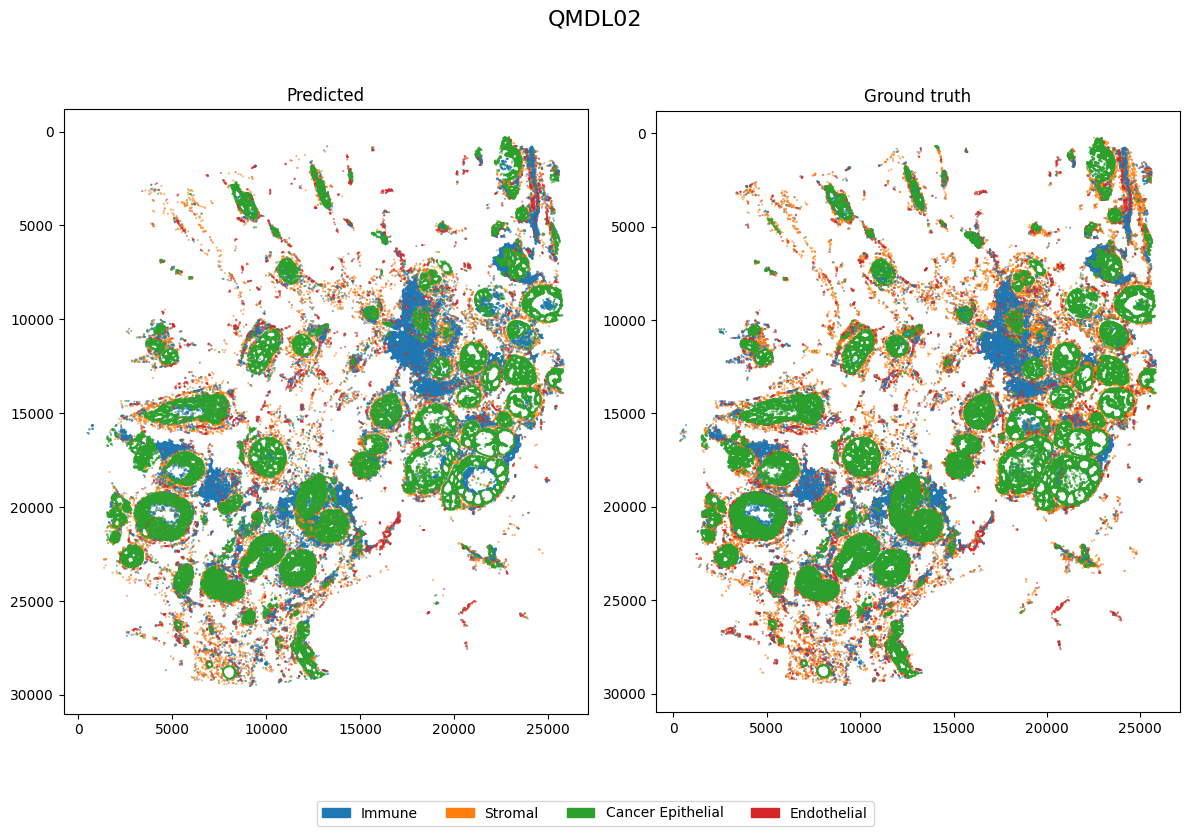

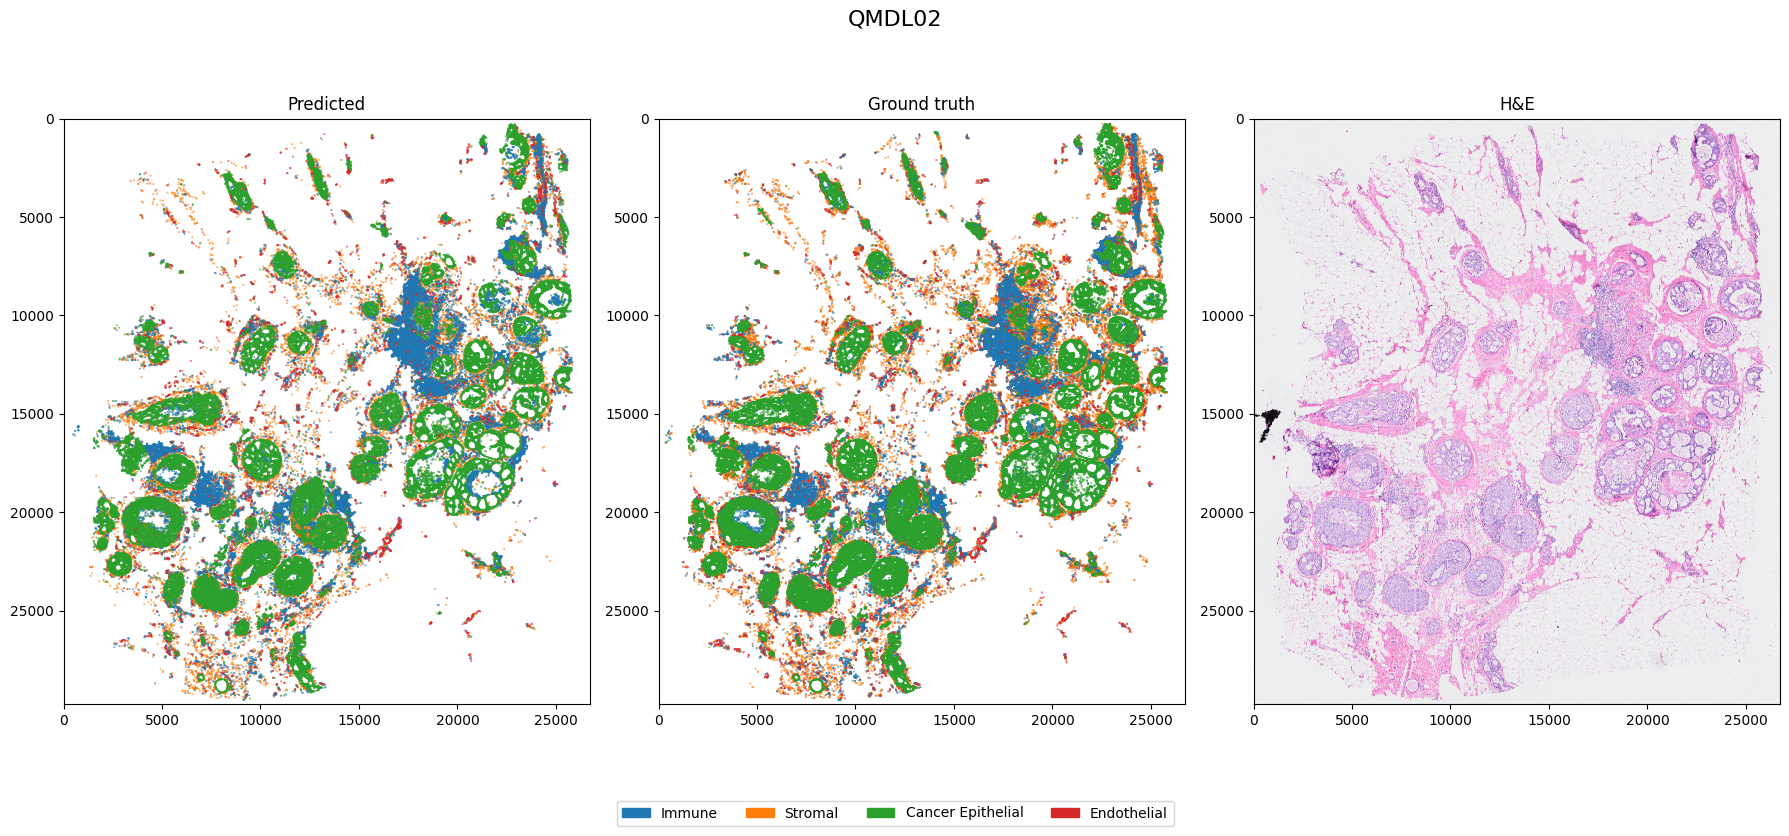

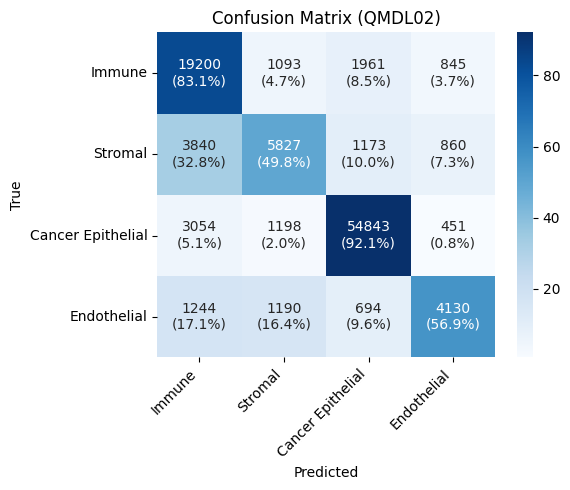

In [7]:
for SAMPLE_ID in [
                #   "QMDL01", 
                  "QMDL02", 
                #   "QMDL03", 
                #   "QMDL04", 
                #   "QMDL05"
                  ]:
    # Load the numpy files
    img_path = PROCESSED / "images" / f"{SAMPLE_ID}.ome.tif"
    result_path = TMP_PATH / f"hovernet_out_test_{SAMPLE_ID}"
    adata_path = PROCESSED / f"annotated_labels/{SAMPLE_ID}/imputed_annotated.h5ad"
    cm = np.load(result_path / "cm.npy")
    preds = np.load(result_path / "preds.npy")
    truths = np.load(result_path / "truths.npy")
    pred_dir = result_path / "centroids_pred/"
    true_dir = result_path / "centroids_truth/"
    paths = np.load(result_path / "types.npy")
    file_map = dict(enumerate([int(Path(p).stem.split('_')[1]) for p in paths]))

    print(f"Shape of confusion matrix: {cm.shape}")
    print(f"Number of predictions: {len(preds)}")
    print(f"Number of ground truths: {len(truths)}")
    print(f"Number of types: {len(paths)}")
    palette = list(TABLEAU_COLORS.values())
    palette = ['#FFFFFF'] + palette

    img = ImageContainer(img_path)

    size = 256
    size = img._get_size(size)
    size = img._convert_to_pixel_space(size)

    y, x = img.shape
    ys, xs = size
    # _assert_in_range(ys, 0, y, name="height")
    # _assert_in_range(xs, 0, x, name="width")

    unique_ycoord = np.arange(start=0, stop=(y // ys + (y % ys != 0)) * ys, step=ys)
    unique_xcoord = np.arange(start=0, stop=(x // xs + (x % xs != 0)) * xs, step=xs)

    ycoords = np.repeat(unique_ycoord, len(unique_xcoord))
    xcoords = np.tile(unique_xcoord, len(unique_ycoord))

    mapping = dict(enumerate(zip(ycoords, xcoords)))

    ordering = list(file_map.values())
    preds = np.moveaxis(preds,3,1)
    truths = np.moveaxis(truths,3,1)
    # Stitch image back together
    size = 256
    img_true = np.zeros((truths.shape[1],ycoords.max()+size, xcoords.max()+size),dtype=np.uint8)

    for n, idx in enumerate(tqdm(ordering)):
        y, x = mapping[idx]
        img_true[:,y:y+size,x:x+size] = truths[n]
        
    img_true = img_true[:,:img.shape[0],:img.shape[1]]

    np.save(result_path / 'truths_mapped.npy', img_true)
    # Stitch image back together
    size = 256
    img_pred = np.zeros((preds.shape[1],ycoords.max()+size, xcoords.max()+size),dtype=np.uint8)

    for n, idx in enumerate(tqdm(ordering)):
        y, x = mapping[idx]
        img_pred[:,y:y+size,x:x+size] = preds[n]
        
    img_pred = img_pred[:,:img.shape[0],:img.shape[1]]

    np.save(result_path / 'preds_mapped.npy', img_pred)
    # TRUE TO USE
    file_list = glob.glob(str(true_dir) + '/' + '*.mat')
    file_list.sort() # ensure same order [1]
    transformed_all = []
    types_all = []

    for file_idx, filename in enumerate(tqdm(file_list[:])):
        filename = os.path.basename(filename)
        basename = filename.split('.')[0]
        true_info = sio.loadmat(str(true_dir) + '/' + basename + '.mat')
        centroids = true_info['inst_centroid']
        pos = mapping[file_map[int(basename)-1]]
        # transformed = centroids + pos
        transformed = centroids + list(reversed(pos))
        types = true_info['inst_type'].astype(int)
        if file_idx == 0:
            transformed_all = transformed
            types_all = types
        else:
            transformed_all = np.concatenate((transformed, transformed_all))
            types_all = np.concatenate((types, types_all))

    cols = list(map(dict(enumerate(palette)).get, types_all.flatten().tolist()))
    with open(result_path / 'transformed_data_true.pkl', 'wb') as f:  # open a text file
        pickle.dump([transformed_all, types_all, cols], f) # serialize the list
    with open(result_path / 'transformed_data_true.pkl', 'rb') as f:  # open a text file
        true_transformed_all, true_types_all, true_cols = pickle.load(f)
    # PRED TO USE
    file_list = glob.glob(str(pred_dir) + '/' + '*.mat')
    file_list.sort() # ensure same order [1]
    transformed_all = []
    types_all = []

    for file_idx, filename in enumerate(tqdm(file_list[:])):
        filename = os.path.basename(filename)
        basename = filename.split('.')[0]
        pred_info = sio.loadmat(str(pred_dir) + '/' + basename + '.mat')
        centroids = pred_info['inst_centroid']
        if centroids.size > 0:
            pos = mapping[int(file_map[int(basename)-1])]
            # transformed = centroids + pos
            transformed = centroids + list(reversed(pos))
            types = pred_info['inst_type'].astype(int)
            if file_idx == 0:
                transformed_all = transformed
                types_all = types
            else:
                transformed_all = np.concatenate((transformed, transformed_all))
                types_all = np.concatenate((types, types_all))

    cols = list(map(dict(enumerate(palette)).get, types_all.flatten().tolist()))
    with open(result_path / 'transformed_data_pred.pkl', 'wb') as f:  # open a text file
        pickle.dump([transformed_all, types_all, cols], f) # serialize the list
    with open(result_path / 'transformed_data_pred.pkl', 'rb') as f:  # open a text file
        pred_transformed_all, pred_types_all, pred_cols = pickle.load(f)
    adata = read_h5ad(adata_path)
    categories = adata.obs['predicted.id'].cat.categories.tolist()
    colors = list(TABLEAU_COLORS.values())
    legend_handles = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
    filtered_legend_handles_ = [
        handle for handle, label in zip(legend_handles, colors)
        if label in set(pred_cols) or label in set(true_cols)
    ]
    categories_map = {
            'B-cells': "Immune",
            'CAFs': "Stromal",
            'Cancer Epithelial': "Cancer Epithelial",
            'Endothelial': "Endothelial",
            'Myeloid': "Immune",
            'Normal Epithelial': "Cancer Epithelial",
            'PVL': "Endothelial",
            'Plasmablasts': "Immune",
            'T-cells': "Immune"
        }
    new_categories = [categories_map[label] for _, label in zip(filtered_legend_handles_, categories)]
    new_colors = [c for _, c in zip(filtered_legend_handles_, colors)]
    filtered_legend_handles = [mpatches.Patch(color=new_colors[i], label=new_categories[i]) for i in range(len(new_categories))]
    fig, axes = plt.subplots(figsize=(12,8),ncols=2)

    axes[0].scatter(pred_transformed_all[:,0], pred_transformed_all[:,1], c=pred_cols, s=0.1)
    axes[1].scatter(true_transformed_all[:,0], true_transformed_all[:,1], c=true_cols, s=0.1)
    axes[0].set_title("Predicted")
    axes[1].set_title("Ground truth")
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)


    fig.suptitle(f'{SAMPLE_ID}', fontsize=16)
    fig.legend(handles=filtered_legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(new_categories))
    fig.tight_layout()
    fig.savefig(PRED_PATH / f"spatial_wsi_{SAMPLE_ID}.png", dpi=300)
    # # swap y,x to be compatible with PIL
    vals = img.data['image'].values.squeeze()
    # # vals = np.moveaxis(vals, 1,0)
    im = Image.fromarray(vals)

    fig, axes = plt.subplots(figsize=(18,8),ncols=3)

    axes[0].scatter(pred_transformed_all[:,0], pred_transformed_all[:,1], c=pred_cols, s=0.1)
    axes[1].scatter(true_transformed_all[:,0], true_transformed_all[:,1], c=true_cols, s=0.1)
    axes[0].set_title("Predicted")
    axes[1].set_title("Ground truth")
    axes[2].set_title("H&E")
    axes[0].set_ylim(0,img.shape[0])
    axes[0].set_xlim(0,img.shape[1])
    axes[1].set_ylim(0,img.shape[0])
    axes[1].set_xlim(0,img.shape[1])
    axes[2].imshow(im, aspect='auto', extent=axes[0].axis(), zorder=-1,origin='lower')
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    axes[2].invert_yaxis()
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
    axes[2].set_aspect(1)

    fig.suptitle(f'{SAMPLE_ID}', fontsize=16)
    fig.legend(handles=filtered_legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(new_categories))
    fig.tight_layout()
    fig.savefig(PRED_PATH / f"spatial_wsi_{SAMPLE_ID}_HE.png", dpi=300, bbox_inches='tight')
    label_dict = dict(enumerate(palette))
    cat_color_dict = dict(zip(new_colors, new_categories))
    cat_to_plot = [cat_color_dict[label_dict[i]] for i in range(1, 5)]

    cm_normalized = cm / cm.sum(axis=1, keepdims=True) * 100
    annotations = np.empty_like(cm[1:5, 1:5]).astype(str)
    for i in range(annotations.shape[0]):
        for j in range(annotations.shape[1]):
            count = cm[1:5, 1:5][i, j]
            percentage = cm_normalized[1:5, 1:5][i, j]
            annotations[i, j] = f"{int(count)}\n({percentage:.1f}%)"

    # Plot confusion matrix with custom annotations
        # Plot confusion matrix with custom annotations
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_normalized[1:5, 1:5], annot=annotations, fmt='', cmap='Blues', 
                xticklabels=cat_to_plot, yticklabels=cat_to_plot, ax=ax)
    plt.title(f'Confusion Matrix ({SAMPLE_ID})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    fig.savefig(PRED_PATH / f"cm_{SAMPLE_ID}.png", dpi=300, bbox_inches='tight')

    classes = cat_to_plot

    metrics_per_class, mean_metrics = calculate_metrics_multiclass_masks(img_true[:-1,...], img_pred[:-1,...], classes)


    print("Metrics Per Class:")
    for metrics in metrics_per_class:
        print(metrics)

    print("\nMean Metrics:")
    print(mean_metrics)

    with open(result_path / 'final_metric_i.pkl', 'wb') as f:  # open a text file
        pickle.dump(metrics_per_class, f) # serialize the list
    with open(result_path / 'final_metric_mean.pkl', 'wb') as f:  # open a text file
        pickle.dump(mean_metrics, f) # serialize the list
        
        
    mask_to_geojson(img_pred[:-1,...], result_path / 'stitched_label_mask_pred.geojson', classes=classes)
    mask_to_geojson(img_true[:-1,...], result_path / 'stitched_label_mask_true.geojson', classes=classes)